In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Define paths
train_dir = 'train'
test_dir = 'test'

# Image dimensions
img_width, img_height = 150, 150
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(img_width, img_height), 
                                                  batch_size=batch_size, 
                                                  class_mode='categorical')

Found 783 images belonging to 2 classes.
Found 783 images belonging to 2 classes.


In [3]:
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # For binary segmentation
    
    model = models.Model(inputs, outputs)
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [4]:
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  # 3 classes: Happy, Sad, Angry

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [5]:
epochs = 250


unet_history = cnn_model.fit(train_generator, 
                            steps_per_epoch=train_generator.samples // batch_size, 
                            validation_data=test_generator, 
                            validation_steps=test_generator.samples // batch_size, 
                            epochs=epochs)



Epoch 1/250
24/24 [==============================] - 17s 686ms/step - loss: 0.2224 - accuracy: 0.9121 - val_loss: 0.0901 - val_accuracy: 0.9766
Epoch 2/250
24/24 [==============================] - 15s 621ms/step - loss: 0.0911 - accuracy: 0.9774 - val_loss: 0.0845 - val_accuracy: 0.9766
Epoch 3/250
24/24 [==============================] - 15s 613ms/step - loss: 0.0800 - accuracy: 0.9760 - val_loss: 0.0857 - val_accuracy: 0.9766
Epoch 4/250
24/24 [==============================] - 15s 612ms/step - loss: 0.0738 - accuracy: 0.9760 - val_loss: 0.0760 - val_accuracy: 0.9766
Epoch 5/250
24/24 [==============================] - 15s 612ms/step - loss: 0.0707 - accuracy: 0.9760 - val_loss: 0.0510 - val_accuracy: 0.9779
Epoch 6/250
24/24 [==============================] - 15s 614ms/step - loss: 0.0589 - accuracy: 0.9774 - val_loss: 0.0434 - val_accuracy: 0.9766
Epoch 7/250
24/24 [==============================] - 15s 626ms/step - loss: 0.0569 - accuracy: 0.9747 - val_loss: 0.0348 - val_accuracy:

24/24 [==============================] - 30s 1s/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0030 - val_accuracy: 0.9987
Epoch 115/250
24/24 [==============================] - 29s 1s/step - loss: 0.0142 - accuracy: 0.9947 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 116/250
24/24 [==============================] - 29s 1s/step - loss: 0.0090 - accuracy: 0.9960 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 117/250
24/24 [==============================] - 29s 1s/step - loss: 0.0052 - accuracy: 0.9960 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 118/250
24/24 [==============================] - 29s 1s/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.0041 - val_accuracy: 0.9987
Epoch 119/250
24/24 [==============================] - 29s 1s/step - loss: 0.0064 - accuracy: 0.9973 - val_loss: 0.0018 - val_accuracy: 0.9987
Epoch 120/250
24/24 [==============================] - 29s 1s/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 121/250

24/24 [==============================] - 29s 1s/step - loss: 5.7969e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9987
Epoch 226/250
24/24 [==============================] - 29s 1s/step - loss: 0.0101 - accuracy: 0.9973 - val_loss: 0.0235 - val_accuracy: 0.9961
Epoch 227/250
24/24 [==============================] - 29s 1s/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.0014 - val_accuracy: 0.9987
Epoch 228/250
24/24 [==============================] - 29s 1s/step - loss: 0.0019 - accuracy: 0.9987 - val_loss: 4.4334e-04 - val_accuracy: 1.0000
Epoch 229/250
24/24 [==============================] - 29s 1s/step - loss: 0.0018 - accuracy: 0.9987 - val_loss: 2.8080e-04 - val_accuracy: 1.0000
Epoch 230/250
24/24 [==============================] - 29s 1s/step - loss: 0.0035 - accuracy: 0.9973 - val_loss: 0.0040 - val_accuracy: 0.9987
Epoch 231/250
24/24 [==============================] - 29s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9987
E

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def calculate_dsc_iou(y_true, y_pred):
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    intersection = np.diag(cm)
    union = np.sum(cm, axis=1) + np.sum(cm, axis=0) - intersection
    
    # Compute Dice Similarity Coefficient (DSC)
    dice = 2 * intersection / (np.sum(cm, axis=1) + np.sum(cm, axis=0))
    
    # Compute IoU
    iou = intersection / union
    
    return dice, iou

def evaluate_model(model, test_generator):
    # Predict on test data
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
    
    # Confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Compute DSC and IoU
    dice, iou = calculate_dsc_iou(y_true, y_pred)
    print(f'DSC: {dice}')
    print(f'IoU: {iou}')

# Evaluate CNN Model
print("U-Net Model Evaluation:")
evaluate_model(cnn_model, test_generator)



U-Net Model Evaluation:
25/25 [==============================] - 7s 289ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.31      0.31      0.31       205
       tumor       0.75      0.75      0.75       578

    accuracy                           0.64       783
   macro avg       0.53      0.53      0.53       783
weighted avg       0.64      0.64      0.64       783

Confusion Matrix:
[[ 63 142]
 [143 435]]
DSC: [0.30656934 0.75324675]
IoU: [0.18103448 0.60416667]


u-net Model Evaluation:
25/25 [==============================] - 7s 279ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.21      0.21      0.21       205
       tumor       0.72      0.72      0.72       578

    accuracy                           0.59       783
   macro avg       0.47      0.47      0.47       783
weighted avg       0.59      0.59      0.59       783



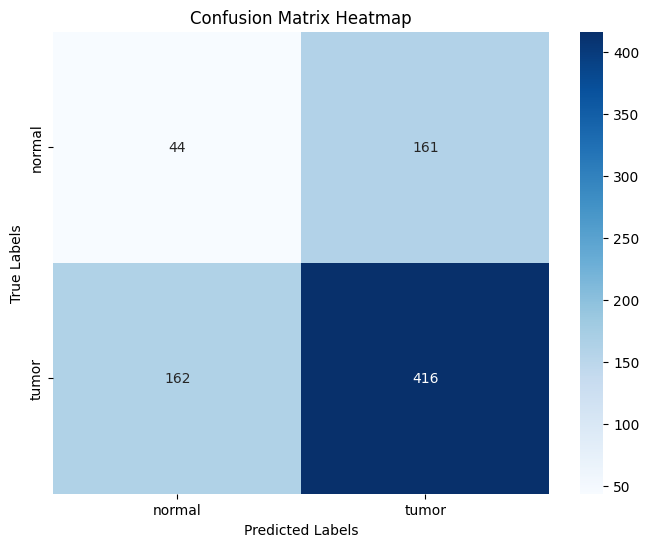

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_generator):
    # Predict on test data
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Evaluate CNN Model
print("u-net Model Evaluation:")
evaluate_model(cnn_model, test_generator)


u-net Model Evaluation:
25/25 [==============================] - 7s 262ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.27      0.27      0.27       205
       tumor       0.74      0.74      0.74       578

    accuracy                           0.62       783
   macro avg       0.51      0.51      0.51       783
weighted avg       0.62      0.62      0.62       783

Confusion Matrix:
[[ 56 149]
 [150 428]]


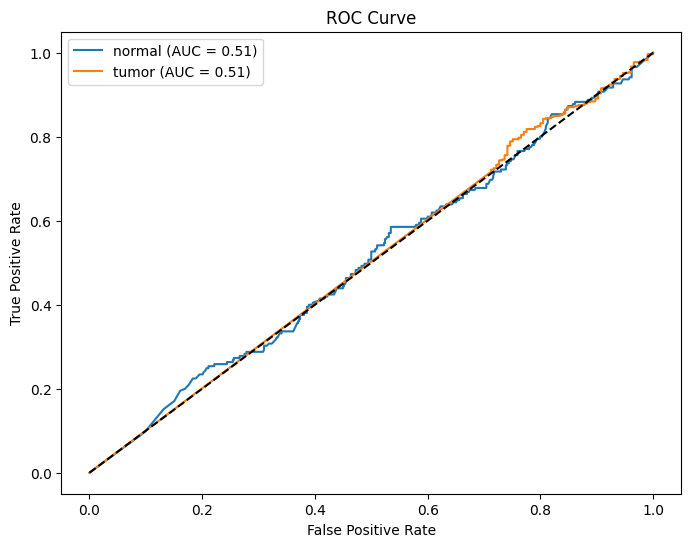

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_generator):
    # Predict on test data
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
    
    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # ROC Curve
    y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]
    
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(test_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Evaluate CNN Model
print("u-net Model Evaluation:")
evaluate_model(cnn_model, test_generator)  
